# Particle marginal Metropolis-Hastings (PMMH)

Notebook about testing PMMH.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [9]:
from src.models.lgm import LGModelParams, LGModel
from src.filters.kalman.kalman_filter import KalmanFilter
from src.filters.pmcmc.pmmh import ParticleMarginalMetropolisHastings
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.auxiliary_pf import AuxiliaryParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

In [10]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# True parameters
true_theta = LGModelParams(
    a=0.7,
    b=1.0,
    sigma_x=1.0,
    sigma_y=0.5,
)

# Initialize model
model = LGModel(rng=rng)

In [11]:
T = 100

x_true, y = simulate_data(model, true_theta, T, rng)

In [12]:
x_true = [x.x_t for x in x_true]  # Extract state values from State objects
x_true = np.array(x_true)
print(x_true.shape)
print(y.shape)

(100, 1)
(100, 1)


In [13]:
N = 1000

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)
apf = AuxiliaryParticleFilter(model, N, resampler=systematic_resampling)

In [14]:
kwargs_for_sampling = {
    "step_a": 0.1,
    "step_b": 0.1,
    "step_sigma_x": 0.1,
    "step_sigma_y": 0.1,
}
    
pmmh = ParticleMarginalMetropolisHastings(bpf, kwargs_for_sampling=kwargs_for_sampling)

In [ ]:
n_chains = 4
results = []

for chain in range(n_chains):
    print(f"Running PMMH chain {chain+1}/{n_chains}...")
    samples, logmarliks, thetas, alphas = pmmh.run(y, n_iter=5000, burnin=0, verbose=True)
    results.append((samples, logmarliks, thetas, alphas))

Running PMMH chain 1/4...
Iteration 10000/40000 - Acceptance Rate: 0.369
Iteration 20000/40000 - Acceptance Rate: 0.188
Iteration 30000/40000 - Acceptance Rate: 0.128
Iteration 40000/40000 - Acceptance Rate: 0.101
Running PMMH chain 2/4...
Iteration 10000/40000 - Acceptance Rate: 0.217
Iteration 20000/40000 - Acceptance Rate: 0.251
Iteration 30000/40000 - Acceptance Rate: 0.239
Iteration 40000/40000 - Acceptance Rate: 0.252
Running PMMH chain 3/4...
Iteration 10000/40000 - Acceptance Rate: 0.294
Iteration 20000/40000 - Acceptance Rate: 0.299
Iteration 30000/40000 - Acceptance Rate: 0.309
Iteration 40000/40000 - Acceptance Rate: 0.304
Running PMMH chain 4/4...
Iteration 10000/40000 - Acceptance Rate: 0.315
Iteration 20000/40000 - Acceptance Rate: 0.331
Iteration 30000/40000 - Acceptance Rate: 0.317
Iteration 40000/40000 - Acceptance Rate: 0.326


In [19]:
burn_in = 1000

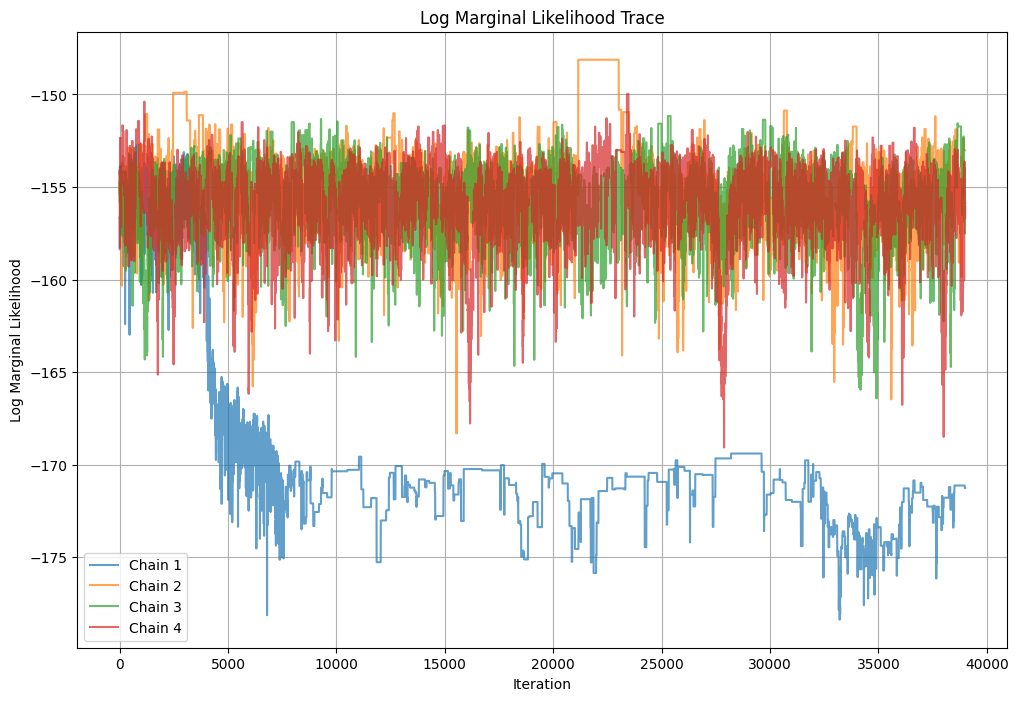

In [21]:
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    samples, logmarliks, thetas, alphas = results[chain]
    plt.plot(logmarliks[burn_in:], label=f"Chain {chain+1}", alpha=0.7)
    
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Likelihood")
plt.title("Log Marginal Likelihood Trace")
plt.legend()
plt.grid()
plt.show()

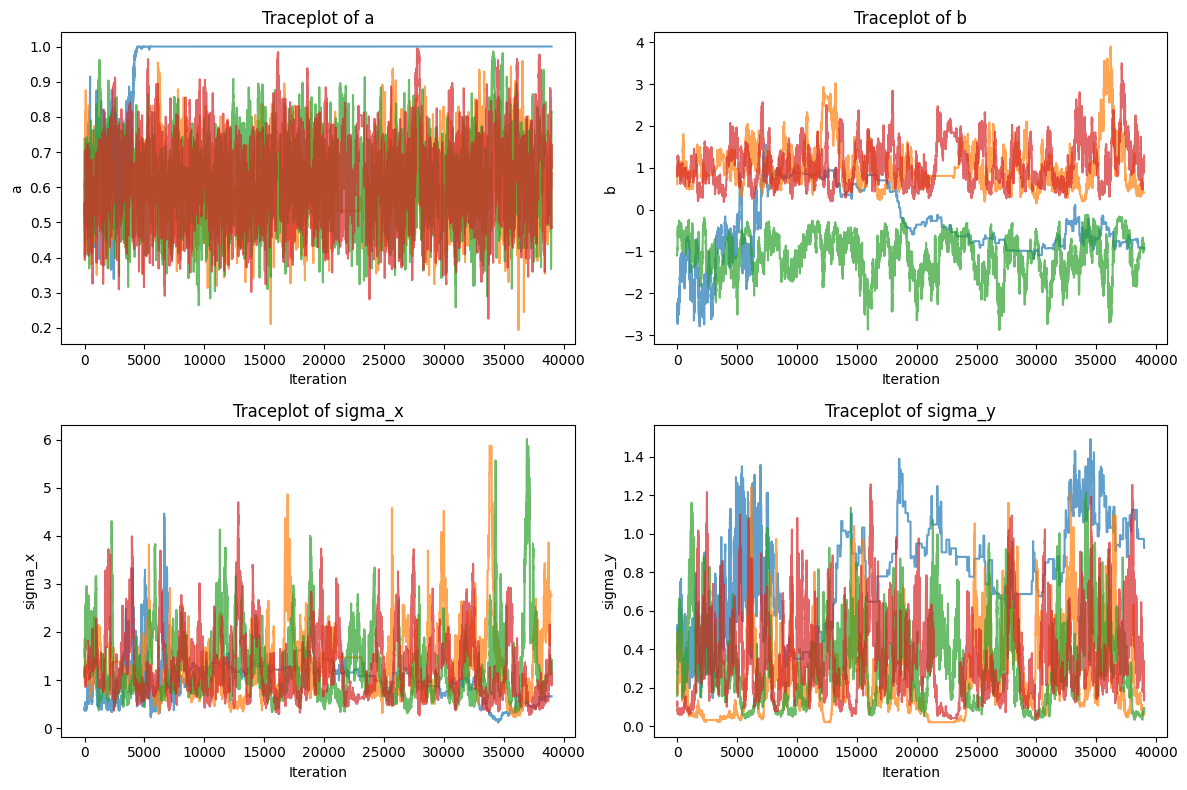

In [23]:
# Traceplot of parameters
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    _, _, thetas, _ = results[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    for i, key in enumerate(thetas_post_burnin.keys()):
        plt.subplot(2, 2, i+1)
        plt.plot(thetas_post_burnin[key], label=f"Chain {chain+1}", alpha=0.7)
        plt.title(f'Traceplot of {key}')
        plt.xlabel('Iteration')
        plt.ylabel(key)
        plt.grid()
plt.tight_layout()
plt.show()

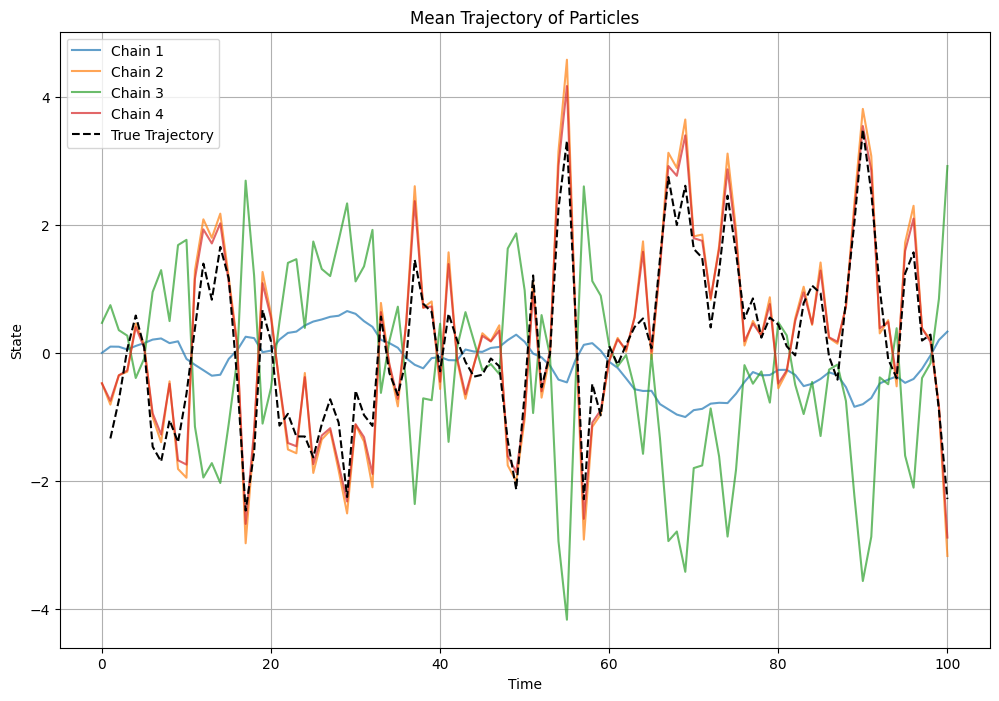

In [30]:
# Now let's look at samples of trajectories
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    samples, _, _, _ = results[chain]
    # Compute mean trajectory post burn-in
    samples_post_burnin = samples[burn_in:]
    np_samples_post_burnin = np.array([[state.x_t for state in sample] for sample in samples_post_burnin])
    mean_trajectory = np.mean(np_samples_post_burnin, axis=0)
    plt.plot(mean_trajectory, label=f"Chain {chain+1}", alpha=0.7)
plt.plot(np.arange(1, len(x_true)+1), x_true, label="True Trajectory", color='black', linestyle='--')
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Mean Trajectory of Particles")
plt.legend()
plt.grid()
plt.show()

Let's explain why we observe such results. Chains 2 and 4 seems to converge to the true values, while chains 1 and 3 do not.

Chain 3 differs from chains 2 and 4 in parameter $b$. Instead of oscillating around $1$, it oscillates around $-1$. This is the identifiability issue. 
Linear Gaussian state-space model is defined as:
$$
\begin{aligned}
x_t &= a x_{t-1} + \sigma_x \epsilon_t, \qquad \epsilon_t \sim \mathcal{N}(0, 1) \\
y_t &= b x_t + \sigma_y \eta_t, \qquad \eta_t \sim \mathcal{N}(0, 1)
\end{aligned}
$$
Now let's define transformation $\tilde{x}_t = -x_t$ and $\tilde{b} = -b$ and keeping other parameters the same. Now we can show that state equation and observation equation are invariant to this transformation:
$$
\begin{aligned}
\tilde{x}_t &= -x_t = -a x_{t-1} - \sigma_x \epsilon_t = a \tilde{x}_{t-1} + \sigma_x (-\epsilon_t) \\
y_t &= b x_t + \sigma_y \eta_t = \tilde{b} \tilde{x}_t + \sigma_y \eta_t
\end{aligned}
$$
Since $\epsilon_t$ and $-\epsilon_t$ have the same distribution, the likelihood of the data given parameters $(a, b, \sigma_x, \sigma_y)$ is the same as the likelihood given parameters $(a, -b, \sigma_x, \sigma_y)$. This means that the model cannot distinguish between these two sets of parameters based on the observed data alone. As a result, the posterior distribution will have two modes corresponding to these parameter sets, leading to identifiability issues.

Chain 1 differs from chains 2 and 4 in parameter $a$. It converges to value $1$. At this value, the state equation becomes
$$
x_t = x_{t-1} + \sigma_x \epsilon_t
$$
This means that the state process is a random walk. 